In [55]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)


In [56]:


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy
from neuromancer.loggers import BasicLogger
import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)



In [57]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1



In [58]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = train_sim['X'][:length].reshape(nbatch, nsteps, nx)
    trainU = train_sim['U'][:length].reshape(nbatch, nsteps, nu)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'r': trainX, 'xn': trainX[:, 0:1, :], 'u': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = dev_sim['X'][:length].reshape(nbatch, nsteps, nx)
    devU = dev_sim['U'][:length].reshape(nbatch, nsteps, nu)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'r': devX, 'xn': devX[:, 0:1, :], 'u': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = test_sim['X'][:length].reshape(1, nbatch*nsteps, nx)
    testU = test_sim['U'][:length].reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'r': testX, 'xn': testX[:, 0:1, :], 'u': testU}

    return train_loader, dev_loader, test_data


In [59]:


nsim = 1000   # number of simulation steps in the dataset
nsteps = 2   # number of prediction horizon steps in the loss function
bs = 50     # minibatching batch size
train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)



In [60]:
theta_1 = library.PolynomialLibrary(nx, nu, 2)

theta_2_funs = [lambda X, u: torch.sqrt(X[:,0]), lambda X, u: torch.sqrt(X[:,1])]
theta_2_names = ["sqrt(x_0)", "sqrt(x_1)"]
theta_2 = library.FunctionLibrary(theta_2_funs, nx, nu, theta_2_names)


fx = sindy.SINDy(library.CombinedLibrary([theta_1, theta_2]))

In [61]:
integrator = integrators.Euler(fx, h=ts)
integrator_node = Node(integrator, ['xn', 'u'], ['x'])
x_bound = Node(lambda x: torch.clamp(x, xmin, xmax), ['x'], ['xn'])
dynamics_model = System([integrator_node, x_bound], nsteps=nsteps, name="dynamics_model")

In [62]:


# %% Constraints + losses:
x = variable("r")
xhat = variable('xn')[:, :-1, :]

# one step loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reference tracking loss
reference_loss = ((xhat == x)^2)
reference_loss.name = "ref_loss"

#sparsity
l1 = variable([x], lambda x: torch.norm(list(fx.parameters())[0]))
loss_l1 = 0.00001*(l1 == 0)        #best so far



In [63]:


# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss, loss_l1]

# create constrained optimization loss
loss = PenaltyLoss(objectives, [])
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)



In [64]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=500,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=400,
    patience=200,
    logger=logger
)

None
Number of parameters: 34


In [65]:
for _ in range(5):
    train_loader, dev_loader, test_data = get_data(gt_model, nsim, nsteps, ts, bs)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps *= 2
    dynamics_model.nsteps = nsteps
    trainer.badcount = 0


epoch: 0	train_loss: 0.93026	dev_loss: 0.81743	eltime:  0.53192
epoch: 1	train_loss: 0.65756	dev_loss: 0.69719	eltime:  0.59402
epoch: 2	train_loss: 0.47964	dev_loss: 0.39020	eltime:  0.65449
epoch: 3	train_loss: 0.21634	dev_loss: 0.23848	eltime:  0.71559
epoch: 4	train_loss: 0.05028	dev_loss: 0.04622	eltime:  0.77821
epoch: 5	train_loss: 0.00973	dev_loss: 0.04497	eltime:  0.84414
epoch: 6	train_loss: 0.01069	dev_loss: 0.05818	eltime:  0.90890
epoch: 7	train_loss: 0.00602	dev_loss: 0.03200	eltime:  0.97111
epoch: 8	train_loss: 0.00327	dev_loss: 0.00873	eltime:  1.03440
epoch: 9	train_loss: 0.00216	dev_loss: 0.00484	eltime:  1.09804
epoch: 10	train_loss: 0.00299	dev_loss: 0.00420	eltime:  1.16100
epoch: 11	train_loss: 0.00227	dev_loss: 0.00242	eltime:  1.22333
epoch: 12	train_loss: 0.00135	dev_loss: 0.00284	eltime:  1.28653
epoch: 13	train_loss: 0.00182	dev_loss: 0.00139	eltime:  1.35027
epoch: 14	train_loss: 0.00095	dev_loss: 0.00148	eltime:  1.40947
epoch: 15	train_loss: 0.00104	dev_l

In [66]:
print(fx)

dx0/dt = -0.013*x0 + 0.055*u0 + -0.018*x0*u1 + 0.016*x1*u0 + 0.025*u0^2 + -0.037*u0*u1 + -0.027*sqrt(x_0) 
dx1/dt = 0.012*u0 + -0.010*x0*u0 + 0.015*x0*u1 + 0.043*u0*u1 + 0.031*sqrt(x_0) + -0.035*sqrt(x_1) 



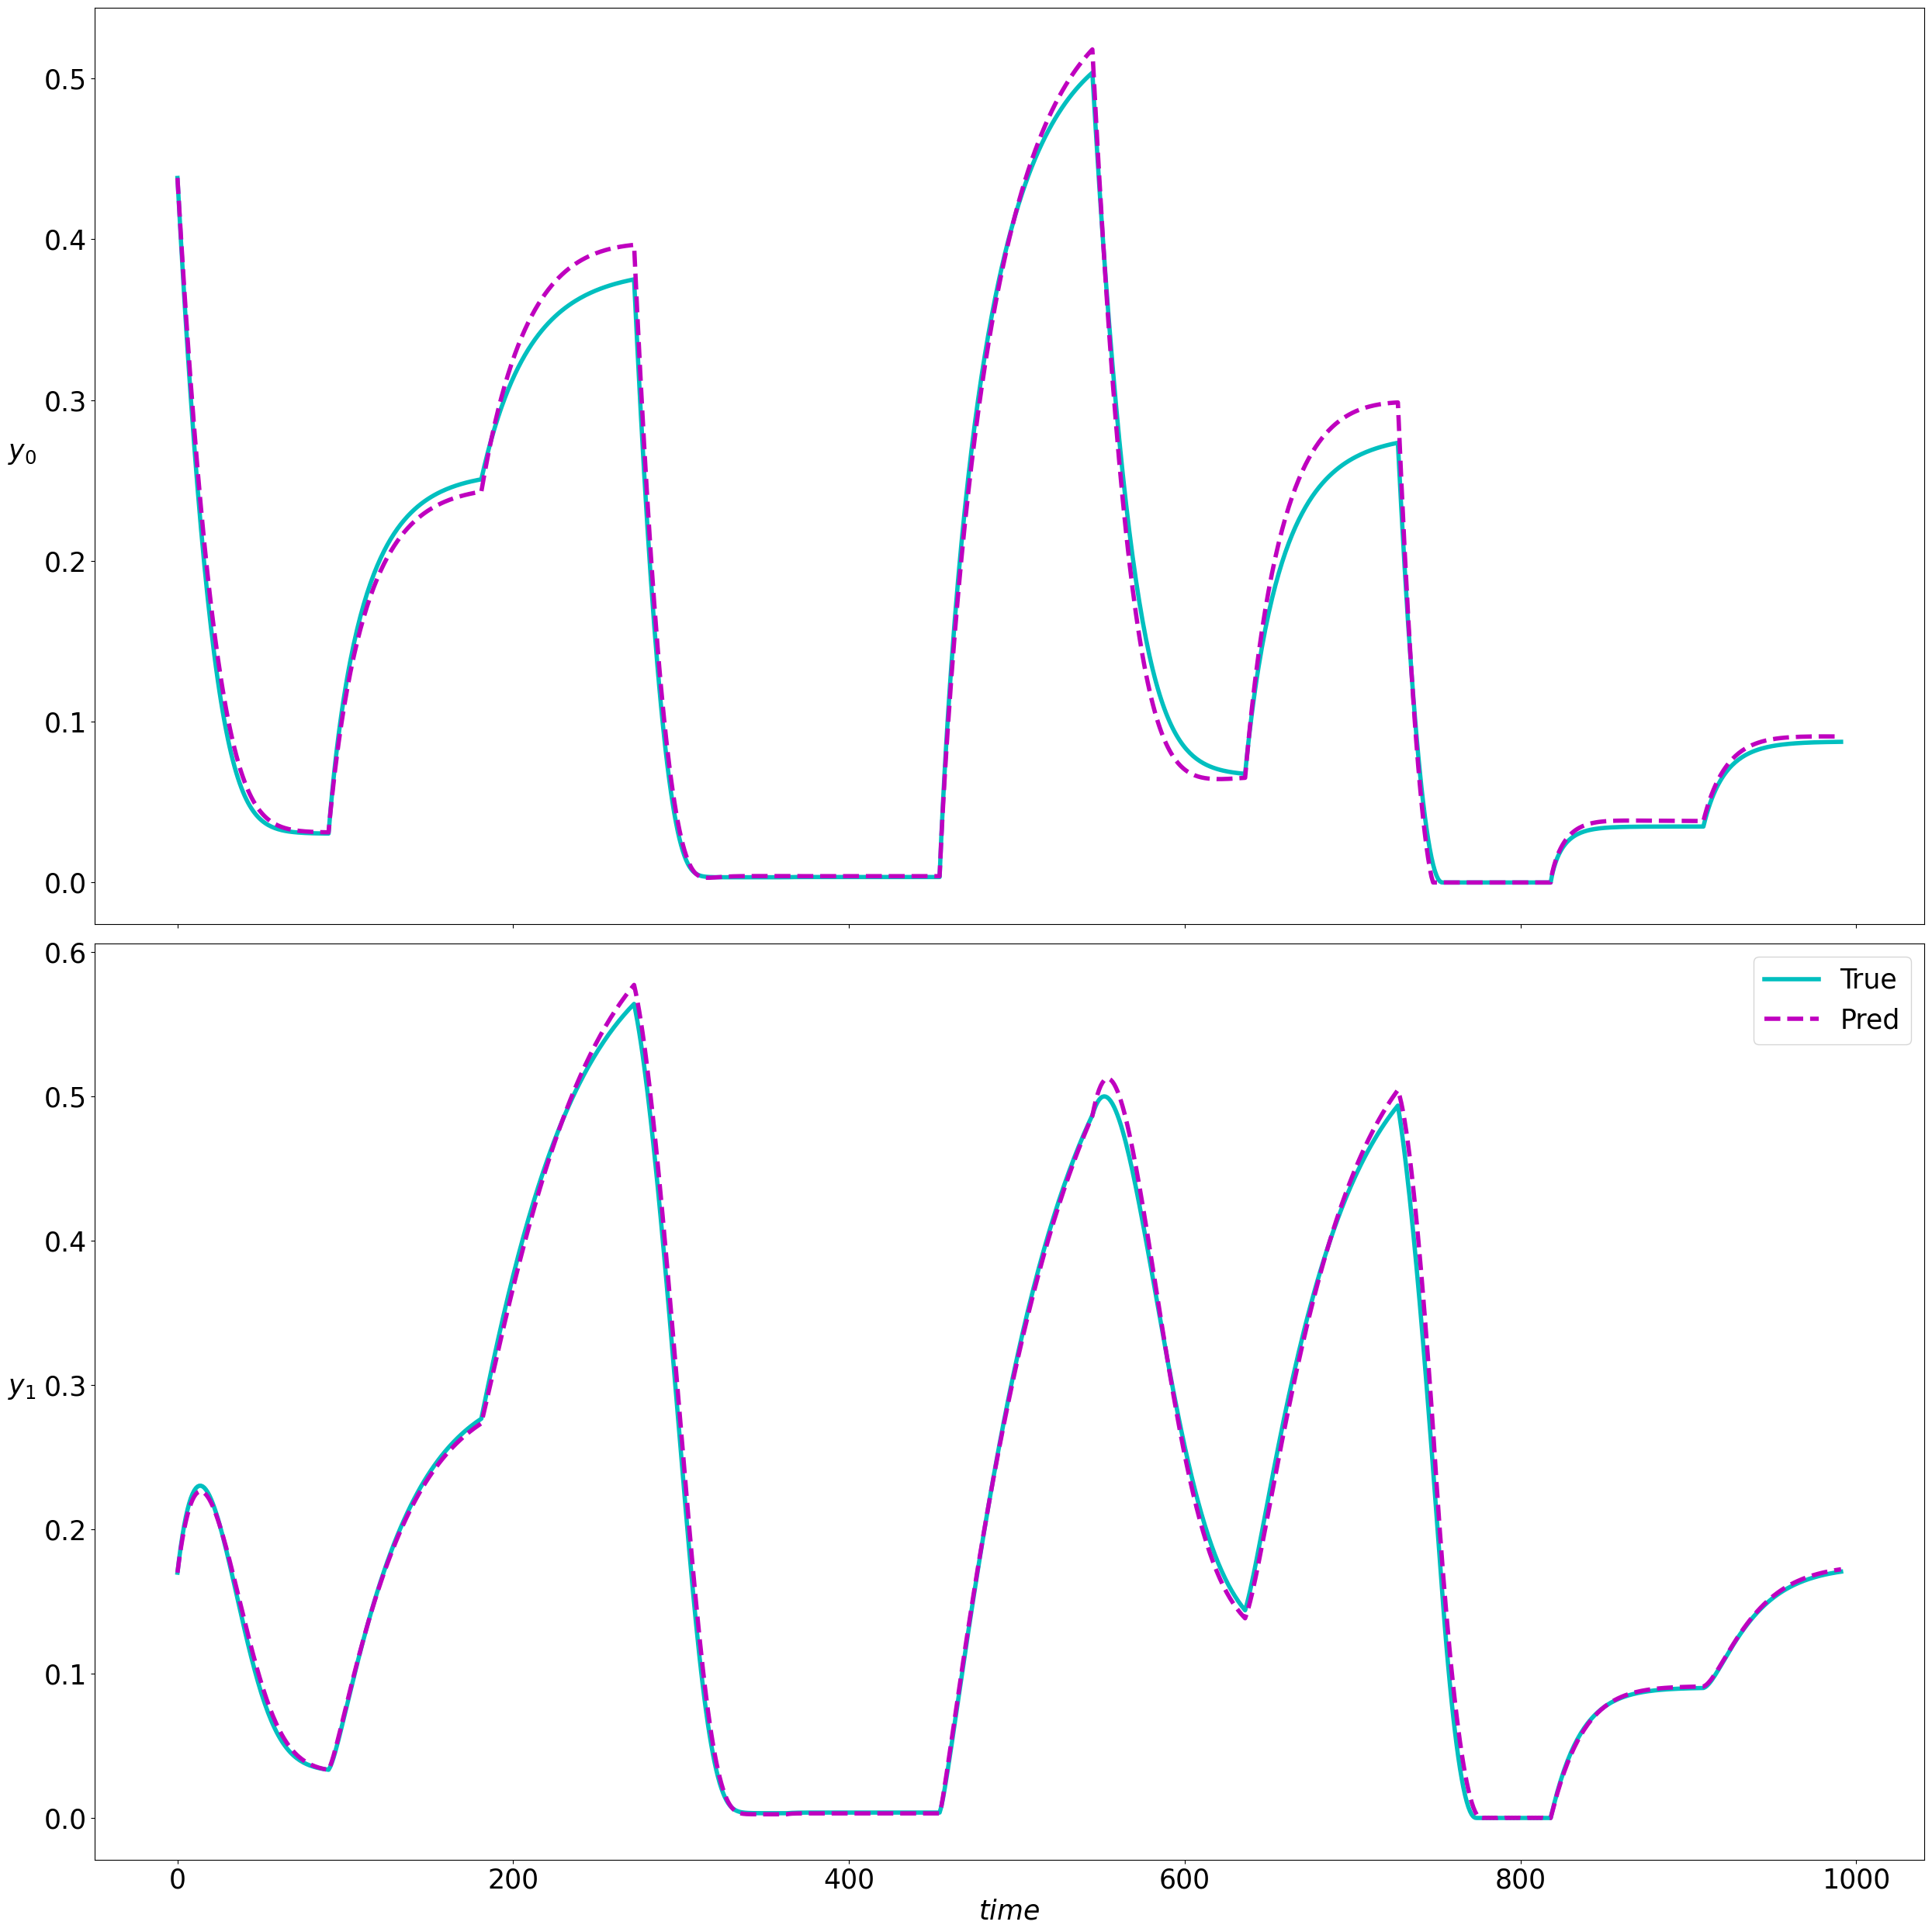

In [67]:
dynamics_model.nsteps = test_data['r'].shape[1]
test_output = dynamics_model(test_data)

pred_traj = test_output['xn'][:, :-1, :]
true_traj = test_data['r']
pred_traj = pred_traj.detach().numpy().reshape(-1, nx)
true_traj = true_traj.detach().numpy().reshape(-1, nx)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
axe.set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()


### SIDNy Policy

dx0/dt = 0.496*x_0 + 0.088*x_1 + 0.307*sin(x_0) + 0.490*sin(x_1) + 0.456*x_0 * x_1 + 0.349*r_0 + 0.022*r_1 + 0.294*r_0^2 + 0.698*r_1^2 + 0.161*x_0 * r_0 + 0.682*x_0 * r_1 + 0.397*x_1 * r_0 + 0.419*x_1 * r_1 
dx1/dt = 0.768*x_0 + 0.132*x_1 + 0.634*sin(x_0) + 0.896*sin(x_1) + 0.632*x_0 * x_1 + 0.402*r_0 + 0.169*r_1 + 0.519*r_0^2 + 0.800*r_1^2 + 0.282*x_0 * r_0 + 0.915*x_0 * r_1 + 0.874*x_1 * r_0 + 0.553*x_1 * r_1 



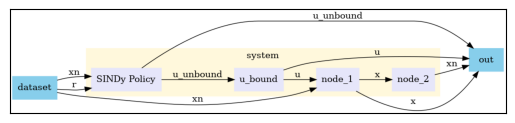

In [85]:
from library import FunctionLibrary
import itertools
torch.manual_seed(0)
# Number of features and control variables
n_features = nx
n_controls = nu

# Create an empty list for features and names
theta_funs = []
theta_names = []

# Degree 1 features (x_i)
theta_funs += [(lambda X, u, i=i: X[:, i]) for i in range(n_features)]
theta_names += [f"x_{i}" for i in range(n_features)]

# Sinusoidal features (sin(x_i))
theta_funs += [(lambda X, u, i=i: torch.sin(X[:, i])) for i in range(n_features)]
theta_names += [f"sin(x_{i})" for i in range(n_features)]

# # Product of x_i and sin(x_i)
# theta_funs += [(lambda X, u, i=i: X[:, i] * torch.sin(X[:, i])) for i in range(n_features)]
# theta_names += [f"x_{i} * sin(x_{i})" for i in range(n_features)]

#Quadratic interaction terms (x_i * x_j)
for i, j in itertools.combinations(range(n_features), 2):
    theta_funs.append(lambda X, u, i=i, j=j: X[:, i] * X[:, j])
    theta_names.append(f"x_{i} * x_{j}")


# Control inputs (u_i)
theta_funs += [(lambda X, u, i=i: u[:, i]) for i in range(n_controls)]
theta_names += [f"r_{i}" for i in range(n_controls)]

# Squared control inputs (u_i^2)
theta_funs += [(lambda X, u, i=i: u[:, i] ** 2) for i in range(n_controls)]
theta_names += [f"r_{i}^2" for i in range(n_controls)]

# Interaction terms (x_i * u_j)
theta_funs += [(lambda X, u, i=i, j=j: X[:, i] * u[:, j]) for i in range(n_features) for j in range(n_controls)]
theta_names += [f"x_{i} * r_{j}" for i in range(n_features) for j in range(n_controls)]

# Create function library
theta_library = FunctionLibrary(theta_funs, n_features, n_controls, theta_names)


# Create SINDy model
policy_sindy = sindy.SINDy(theta_library)
print(policy_sindy)

policy_node = Node(policy_sindy,  ['xn', 'r'], ['u_unbound'], name="SINDy Policy")
u_bound = Node(lambda u: torch.sigmoid(u) * (umax-umin) + umin, ['u_unbound'], ['u'], name="u_bound")

sindy_system = System([policy_node, u_bound, integrator_node, x_bound], nsteps=nsteps)
sindy_system.show()

In [86]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model



In [87]:
def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader

nsteps = 10  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)

In [88]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion

#sparsity
l1 = variable([x], lambda y: torch.norm(list(policy_node.parameters())[0], p=1))
loss_l1 = 0.001*(l1 == 0)

# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss, loss_l1]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]



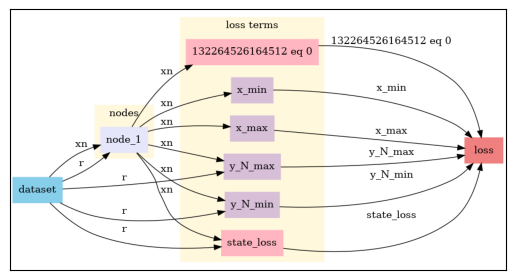

In [89]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [sindy_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [90]:
optimizer = torch.optim.AdamW(policy_node.parameters(), lr=0.01)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                        stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    None,
    None,
    optimizer=optimizer,
    epochs=1000,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=200,
    patience=30,
    logger=logger
)

None
Number of parameters: 60


In [91]:
for _ in range(5):
    print(f'************   training with {nsteps} steps   ************   ')
    train_loader, dev_loader = get_policy_data(nsteps, n_samples)
    trainer.train_data, trainer.dev_data = train_loader, dev_loader
    trainer.problem = problem

    # Train control policy
    best_model = trainer.train()

    # load best trained model
    trainer.model.load_state_dict(best_model)

    nsteps += 10
    sindy_system.nsteps = nsteps
    trainer.badcount = 0


************   training with 10 steps   ************   
epoch: 0	train_loss: 3.68077	dev_loss: 3.78920	eltime:  1.12008
epoch: 1	train_loss: 3.47450	dev_loss: 3.59404	eltime:  1.67611
epoch: 2	train_loss: 3.21134	dev_loss: 3.33999	eltime:  2.22553
epoch: 3	train_loss: 2.91643	dev_loss: 3.08799	eltime:  2.77505
epoch: 4	train_loss: 2.72181	dev_loss: 2.91696	eltime:  3.33605
epoch: 5	train_loss: 2.58392	dev_loss: 2.77675	eltime:  3.88859
epoch: 6	train_loss: 2.47908	dev_loss: 2.67594	eltime:  4.49828
epoch: 7	train_loss: 2.39747	dev_loss: 2.59747	eltime:  5.10866
epoch: 8	train_loss: 2.33269	dev_loss: 2.53564	eltime:  5.67967
epoch: 9	train_loss: 2.27972	dev_loss: 2.48465	eltime:  6.29927
epoch: 10	train_loss: 2.23591	dev_loss: 2.44241	eltime:  6.87826
epoch: 11	train_loss: 2.19899	dev_loss: 2.40650	eltime:  7.46189
epoch: 12	train_loss: 2.16768	dev_loss: 2.37597	eltime:  8.03648
epoch: 13	train_loss: 2.14055	dev_loss: 2.34970	eltime:  8.61932
epoch: 14	train_loss: 2.11690	dev_loss: 2.32

In [51]:
nsteps = 300
torch.manual_seed(0)
seed = 20
rng = np.random.default_rng(seed)
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=3, rng=rng)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

In [52]:
# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
gt_integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
gt_integrator_node = Node(gt_integrator, ['xn', 'u'], ['x'], name='model')


In [53]:
import copy

gt_system_sindy_policy = copy.deepcopy(sindy_system)
gt_system_sindy_policy.nodes[2] = gt_integrator_node

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

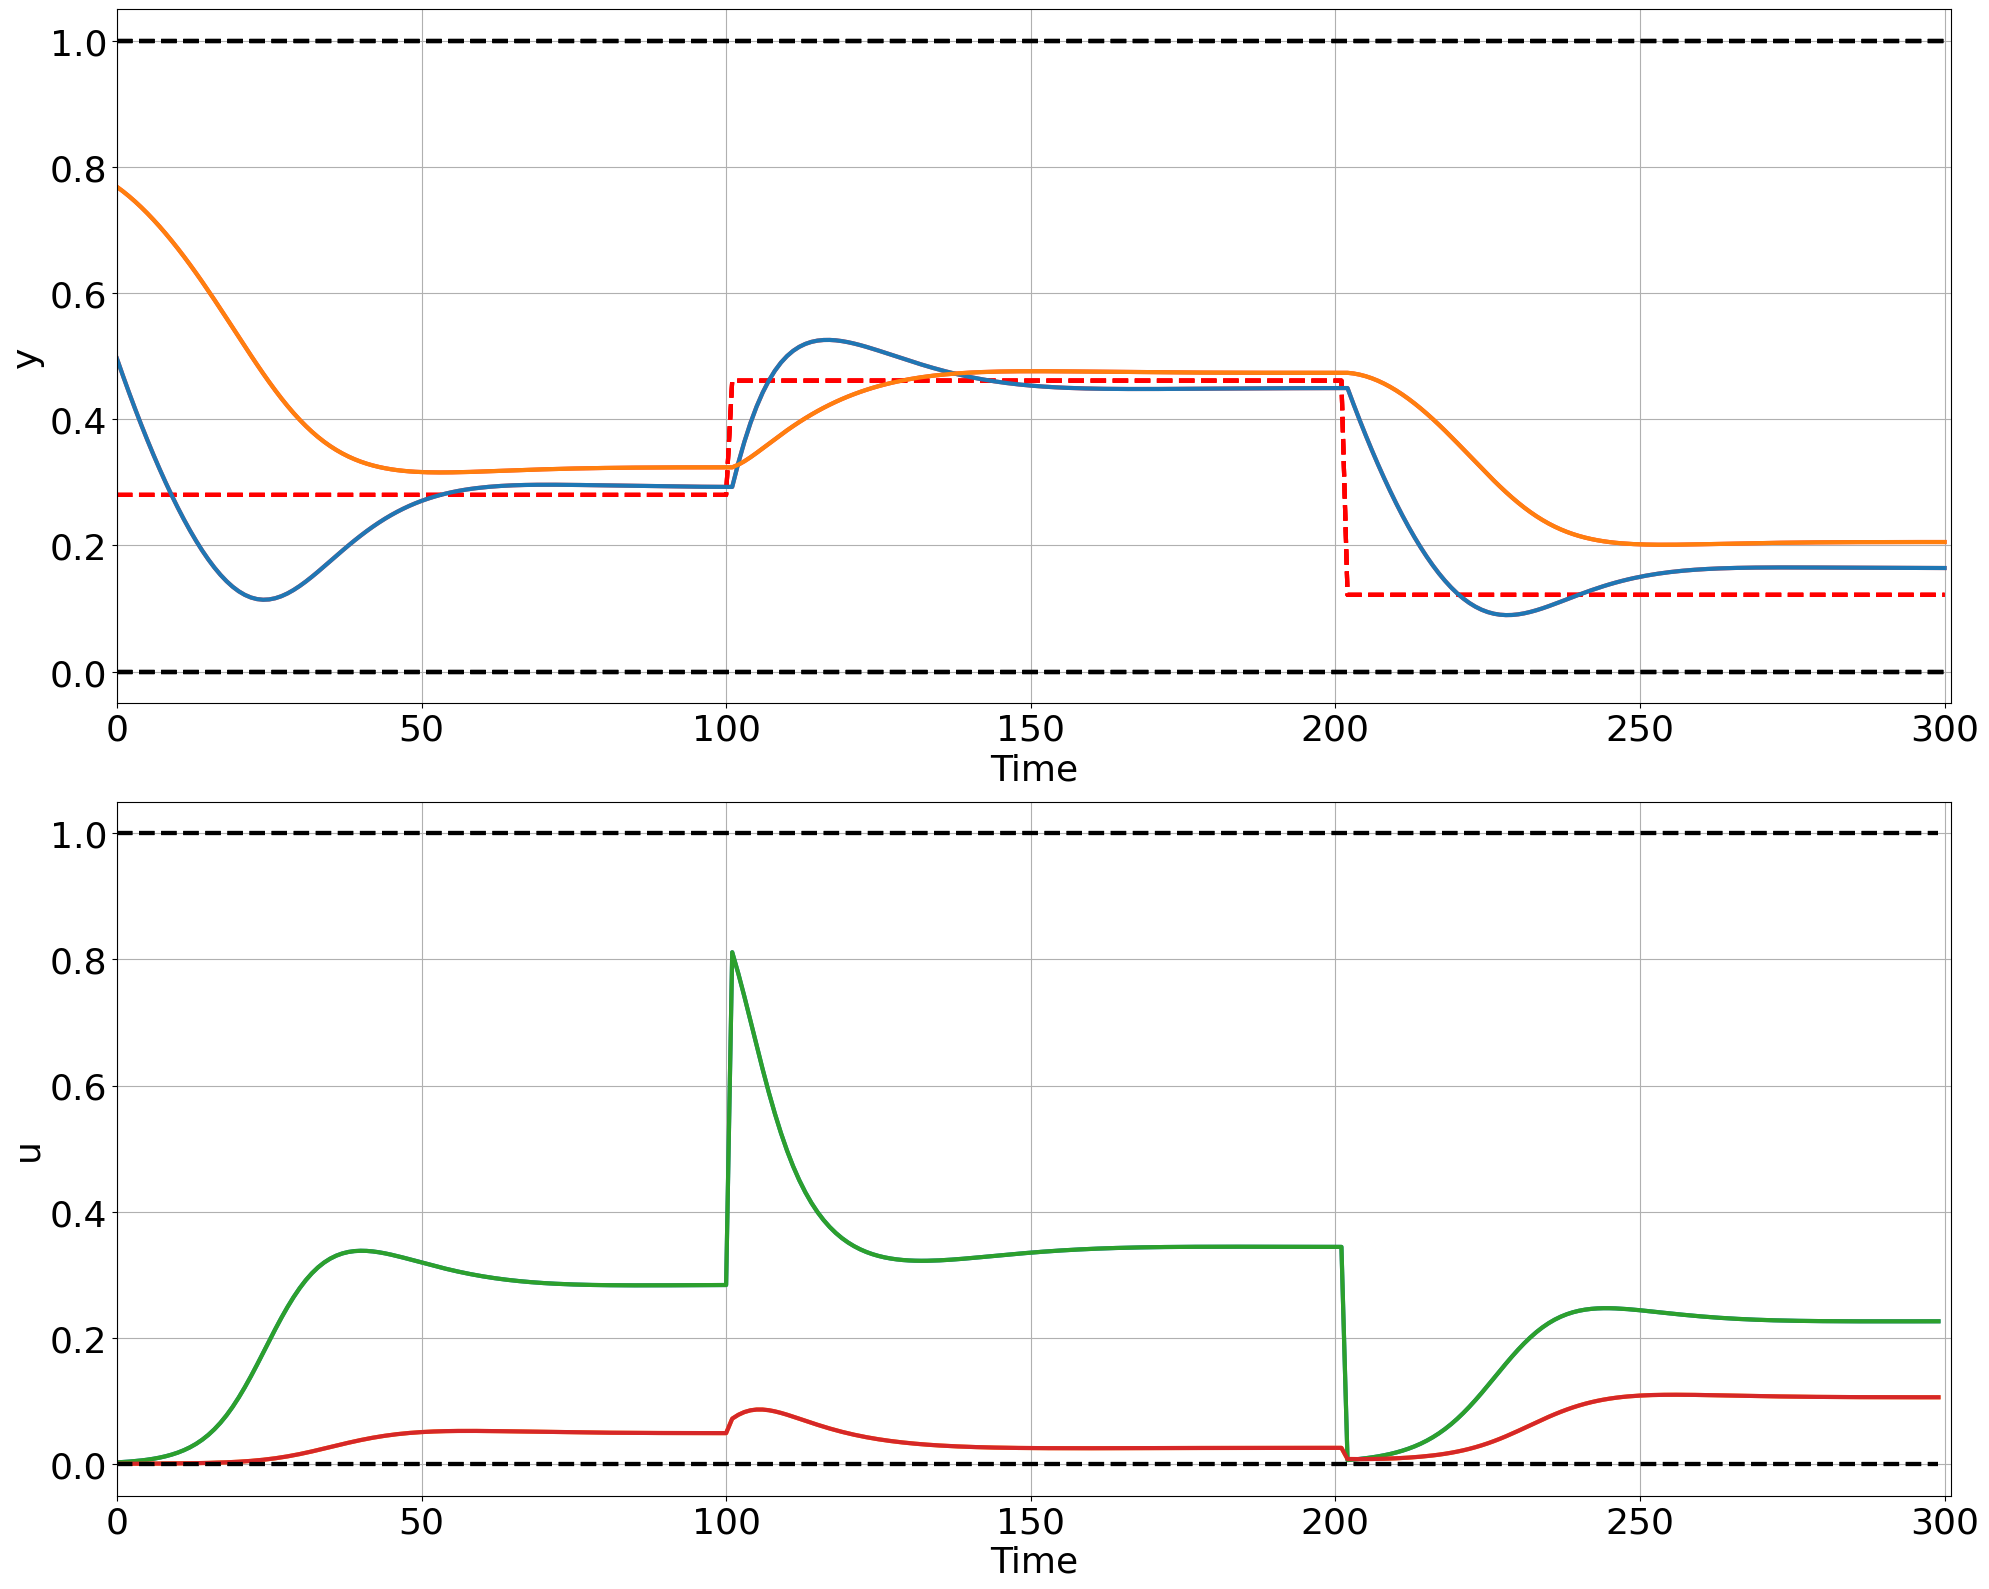

In [54]:
gt_system_sindy_policy.nsteps = nsteps
# perform closed-loop simulation
trajectories = gt_system_sindy_policy(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)